In [2]:
# notebooks/01_lid_driven_cavity.ipynb

using NavalLBM
using Plots
using BenchmarkTools

# Para animações ou plots interativos no notebook
# (pode ser :gr, :plotly, :pyplot)
gr() 

print("Notebook 01: Lid-Driven Cavity Simulation\n")

Notebook 01: Lid-Driven Cavity Simulation


In [7]:
# --- 1. Parâmetros da Simulação ---

# Física
const T = Float64       # Tipo de dado (Float64)
const REYNOLDS = 200.0  # Número de Reynolds alvo (define a física)
const U_LID = 0.1       # Velocidade da tampa (m/s em unidades LBM)
const NX = 100          # Resolução X
const NY = 100          # Resolução Y

# Cálculo de Parâmetros LBM
# Para LDC, a viscosidade cinemática `nu` é derivada de Re = U * L / nu
# Onde L (comprimento) = NY.
# nu = U_LID * NY / REYNOLDS
const NU = (U_LID * T(NY)) / REYNOLDS

# Em LBM, nu = (tau - 0.5) / 3.0 (com cs^2 = 1/3)
# TAU = 3.0 * nu + 0.5
const TAU = 3.0 * NU + 0.5

# Simulação
const MAX_STEPS = 10000 # Número total de passos de tempo
const PLOT_EVERY = 200  # Frequência de atualização do plot

print("--- Simulation Parameters ---\n")
print("Grid:     $(NX) x $(NY)\n")
print("Re:       $(REYNOLDS)\n")
print("U_lid:    $(U_LID)\n")
print("Visc (nu): $(NU)\n")
print("Tau (τ):   $(TAU)\n")
print("-----------------------------\n")

# --- 2. Inicialização ---

# 2.1. Alocar e inicializar o estado (fluido em repouso)
state = initialize_state(NX, NY, T(TAU), T=T)

# 2.2. Criar a máscara da cavidade (3 paredes)
create_cavity_mask!(state)

print("State initialized. Ready to simulate.\n")

--- Simulation Parameters ---
Grid:     100 x 100
Re:       200.0
U_lid:    0.1
Visc (nu): 0.05
Tau (τ):   0.65
-----------------------------
State initialized. Ready to simulate.


Starting main simulation loop...
Step [200/10000]
Step [400/10000]
Step [600/10000]
Step [800/10000]
Step [1000/10000]
Step [1200/10000]
Step [1400/10000]
Step [1600/10000]
Step [1800/10000]
Step [2000/10000]
Step [2200/10000]
Step [2400/10000]
Step [2600/10000]
Step [2800/10000]
Step [3000/10000]
Step [3200/10000]
Step [3400/10000]
Step [3600/10000]
Step [3800/10000]
Step [4000/10000]
Step [4200/10000]
Step [4400/10000]
Step [4600/10000]
Step [4800/10000]
Step [5000/10000]
Step [5200/10000]
Step [5400/10000]
Step [5600/10000]
Step [5800/10000]
Step [6000/10000]
Step [6200/10000]
Step [6400/10000]
Step [6600/10000]
Step [6800/10000]
Step [7000/10000]
Step [7200/10000]
Step [7400/10000]
Step [7600/10000]
Step [7800/10000]
Step [8000/10000]
Step [8200/10000]
Step [8400/10000]
Step [8600/10000]
Step [8800/10000]
Step [9000/10000]
Step [9200/10000]
Step [9400/10000]
Step [9600/10000]
Step [9800/10000]
Step [10000/10000]
Simulation loop finished.


[ Info: Saved animation to c:\Users\afmn\Desktop\TCC JULIA\V8\notebooks\notebooks\lid_driven_cavity.gif


Plots.AnimatedGif("c:\\Users\\afmn\\Desktop\\TCC JULIA\\V8\\notebooks\\notebooks\\lid_driven_cavity.gif")
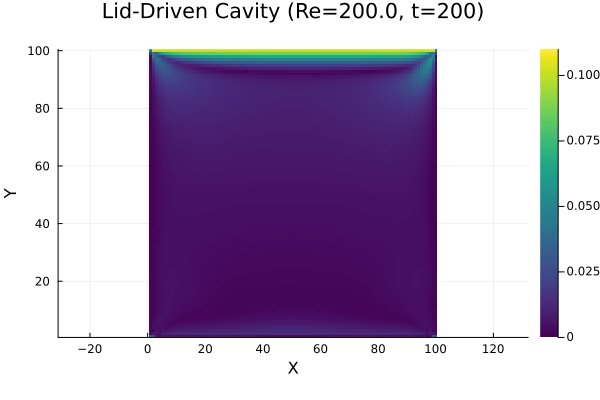

In [8]:
print("Starting main simulation loop...\n")

# Cria o object Animation()
anim = Animation()

# Configurar uma animação
for t in 1:MAX_STEPS
    
    # O "MOTOR" LBM
    
    # 1. CALCULAR MACROS:
    calculate_macros!(state)

    # 2. COLISÃO:
    collision_bgk!(state)
    
    # 3. STREAMING (PROPAGAÇÃO):
    streaming!(state)
    
    # 4. CONTORNOS (SOBRESCRITA DE f_in):
    apply_bounce_back!(state)
    apply_lid_velocity!(state, T(U_LID))

    
    # Plotar a cada N passos
    if t % PLOT_EVERY == 0
        
        # 1. O 'print' vem ANTES do plot, para não ser "capturado".
        print("Step [$(t)/$(MAX_STEPS)]\n")
        
        # Calcular a magnitude da velocidade
        vel_magnitude = sqrt.(state.u.^2 .+ state.v.^2)
        
        # 2. Capturamos o plot em uma variável 'plt'
        plt = heatmap(
            vel_magnitude', 
            aspect_ratio=:equal, 
            c=:viridis, 
            clim=(0, U_LID * 1.1),
            title="Lid-Driven Cavity (Re=$(REYNOLDS), t=$(t))",
            xlabel="X", 
            ylabel="Y"
        )
        
        # 3. Adicionamos manualmente o plot 'plt' à animação
        frame(anim, plt)
    end
end

print("Simulation loop finished.\n")

# Esta linha agora funciona perfeitamente
gif(anim, "lid_driven_cavity.gif", fps = 15)

In [6]:
"""
Helper function to benchmark one complete simulation step.
"""
function simulation_step!(state, u_lid)
    calculate_macros!(state)
    collision_bgk!(state)
    streaming!(state)
    apply_bounce_back!(state)
    apply_lid_velocity!(state, u_lid)
    return nothing
end

# Reinicializar o estado para um teste justo
state = initialize_state(NX, NY, T(TAU), T=T)
create_cavity_mask!(state)
u_lid_val = T(U_LID)

print("\nBenchmarking one full simulation step...\n")
print("(This runs all 5 kernels in sequence)\n")

# @btime (do BenchmarkTools.jl) é mais preciso que @time
# Usamos '$' para "interpolar" as variáveis, garantindo
# que o benchmark meça apenas o código da função.
@btime simulation_step!($state, $u_lid_val)

print("Benchmark finished. Check 'allocs' above (should be 0).\n")


Benchmarking one full simulation step...
(This runs all 5 kernels in sequence)
  417.550 ms (0 allocations: 0 bytes)
Benchmark finished. Check 'allocs' above (should be 0).


Generating final high-quality vector plot (Interpolations + Makie)...
Plot salvo em 'lid_driven_streamplot.svg' e 'lid_driven_streamplot.png'.


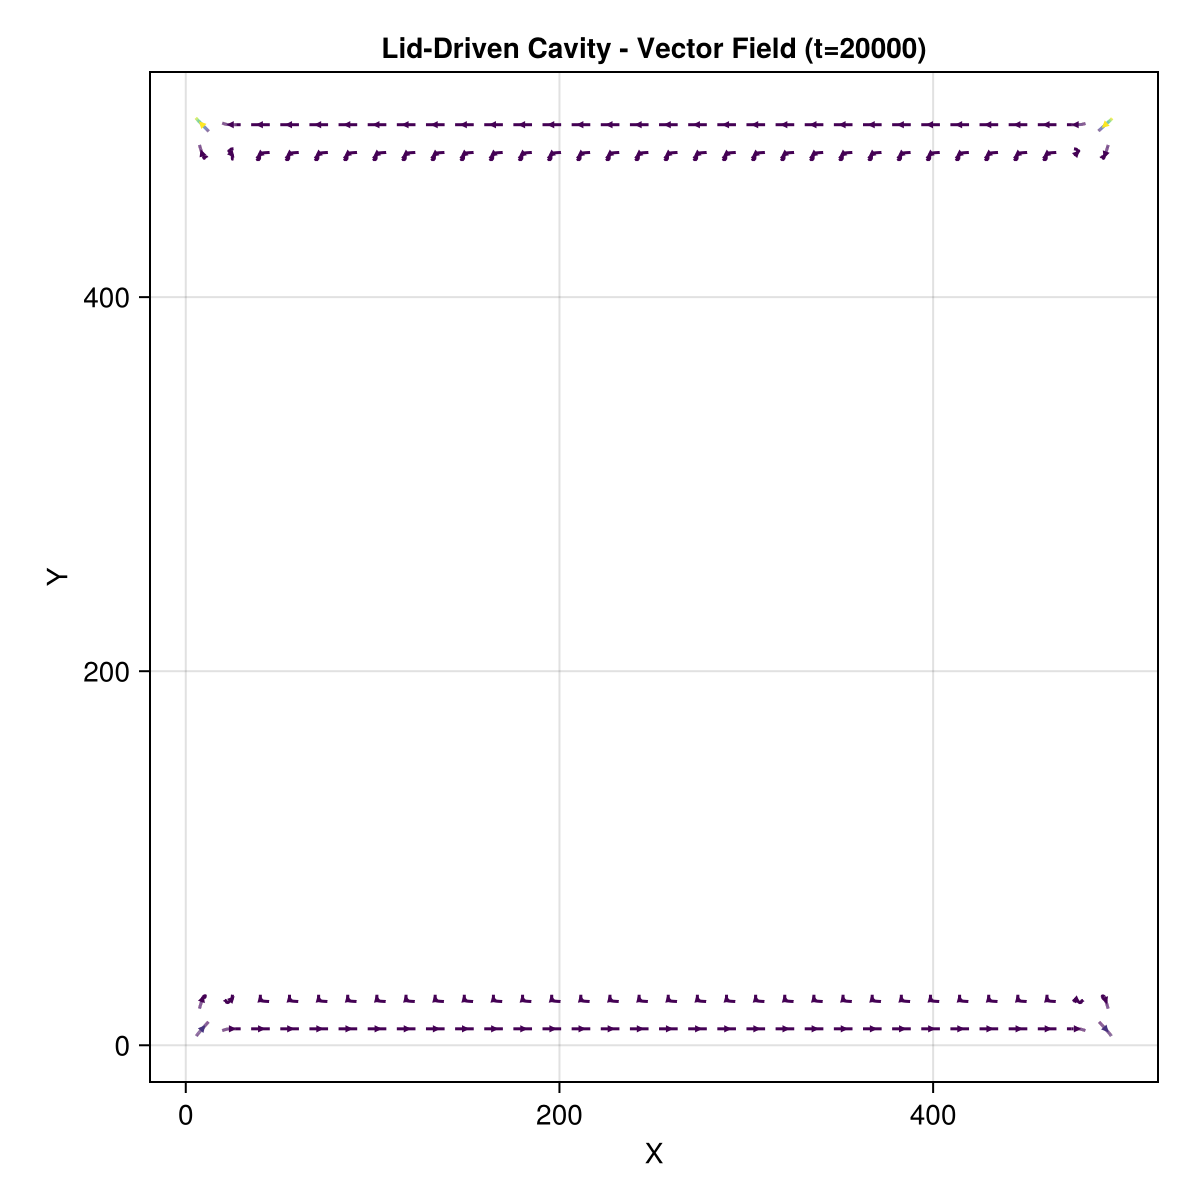

In [7]:
using CairoMakie
using Interpolations

print("Generating final high-quality vector plot (Interpolations + Makie)...\n")

# --- 1. Preparação dos Eixos e Dados ---
# Nossos dados 'state.u' são (i, j) = (x, y)
const T_PLOT = Float32
x_range = 1f0:T(NX) # Eixo X (para interpolação)
y_range = 1f0:T(NY) # Eixo Y (para interpolação)

# Converter para Float32 (sem transpor!)
u_data = Float32.(state.u)
v_data = Float32.(state.v)

# --- 2. Criar Funções de Interpolação ---
# Criamos uma "grade" de interpolação.
# A[i, j] corresponde a (x_range[i], y_range[j])
# (extrapolation_bc=0.0) trata bordas, dizendo que a vel. é 0 fora do domínio
u_itp = linear_interpolation(
    (x_range, y_range), u_data, extrapolation_bc=0.0
)
v_itp = linear_interpolation(
    (x_range, y_range), v_data, extrapolation_bc=0.0
)

# --- 3. Criar a Função de Campo Vetorial ---
# Esta é a função 'f(x, y)' que o streamplot realmente quer.
# Ela pode ser chamada para qualquer (x, y) float, não apenas inteiros.
function vel_field(x, y)
    u_val = u_itp(x, y) # Chama o interpolador
    v_val = v_itp(x, y) # Chama o interpolador
    return Point2f(u_val, v_val)
end

# --- 4. Plotar usando a Assinatura de Função (Mais Robusta) ---
fig = Figure(size = (600, 600))
ax = Axis(
    fig[1, 1], 
    title="Lid-Driven Cavity - Vector Field (t=$(MAX_STEPS))",
    xlabel="X",
    ylabel="Y",
    aspect=DataAspect()
)

# A assinatura agora é: (eixos, função, range_x, range_y)
streamplot!(
    ax,
    vel_field, # <-- Passando nossa função
    x_range,   # <-- Onde plotar em x
    y_range,   # <-- Onde plotar em y
    density = 1.5,
    arrow_size = 5
)

# Salvar o plot final
save("lid_driven_streamplot.svg", fig)
save("lid_driven_streamplot.png", fig)
print("Plot salvo em 'lid_driven_streamplot.svg' e 'lid_driven_streamplot.png'.\n")

# Exibir a figura
fig